# Total-mRNA-aware differential analysis

**Authors:** Qiuyu Lian

In this tutorial, we introduce how to perform total-mRNA-aware differential analysis between two cell types with `TOMAS`.

In [ ]:
import tomas as tm
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
import copy

In [ ]:
adata = sc.read_h5ad('./tomas/output/Tcells/adata_all.h5ad')

## Toal-mRNA-ratio-based UMI correction

In [6]:
sgl_idx = [d for d in adata.obs_names if adata.obs.loc[d,'danno'].startswith('Homo')]
adata_sgl = adata[sgl_idx]


In [18]:
adata_sgl_rc = tm.auxi.correctUMI(adata_sgl, 
                                 groupby='danno', 
                                 ratios={'Homo-naive':1,'Homo-activated':4.3}, 
                                 logUMIby='log10_totUMIs')


  0%|          | 0/8076 [00:00<?, ?it/s]

Correct UMIs of population Homo-activated


100%|██████████| 8076/8076 [01:01<00:00, 131.43it/s]


In [173]:
(adata_sgl.varm['para_diri']==1e-323).sum()

Homo-naive        6223
Homo-activated    4744
dtype: int64

In [19]:
adata_sgl_rc.obs['danno'] = copy.deepcopy(adata_sgl.obs['danno'].values)
adata_sgl_rc.varm['para_diri'] = adata_sgl.varm['para_diri'].values
adata_sgl_rc.obs['rc_total_UMIs'] = np.ravel(adata_sgl_rc.X.sum(1))
adata_sgl_rc.obs['rc_log10_totUMIs'] = np.log10(adata_sgl_rc.obs['rc_total_UMIs'])


## Likelihood-ratio-test (LRT)-based DE

In [20]:
tm.fit.logN_para(adata_sgl_rc,
                 logNby='rc_log10_totUMIs',
                 groupby='danno',
                 groups=['Homo-naive','Homo-activated'],
                 inplace=True,
                 datatype='rc',
                 prt=False)


In [2]:
#adata_sgl_rc.write_h5ad('./tomas/output/Tcells/adata_sgl_rc.h5ad')
adata_sgl_rc = sc.read_h5ad('./prepareForRepo/re_test/test/adata_sgl_rc.h5ad')


In [3]:
lrt_DE_dic = tm.lrt.total_mRNA_aware_DE(adata_sgl_rc, groupby='danno', reference='Homo-naive')


LRT-based DE: Homo-activated vs Homo-naive. This may take a long time. Please wait...


100%|██████████| 431/431 [06:56<00:00,  1.03it/s]


Time cost: 417.8166649341583 seconds.


Global scaling DE

We use [scanpy](https://scanpy.readthedocs.io/en/stable/index.html) for global-scaling-normalization-based DE. 

In [7]:
adata_10k = sc.AnnData(adata_sgl.X.toarray())
adata_10k.var_names = adata_sgl.var_names
adata_10k.obs['danno'] = adata_sgl.obs['danno'].values
sc.pp.normalize_total(adata_10k, target_sum=1e4)
sc.pp.log1p(adata_10k)
sc.tl.rank_genes_groups(adata_10k, 
                        groupby='danno',
                        method='wilcoxon',
                        reference='Homo-naive')

Compare global-scaling-DE and ratio-corrected DE

In [8]:
lrt_df = lrt_DE_dic['Homo-activated']
gs_df = tm.lrt.extract_DE(adata_10k,pval_cutoff=0.05,logFC_cutoff=0)

In [9]:
de_df = tm.lrt.summarize2DE(gs_df,lrt_df,group='Homo-activated',pval_cutoff = 0.05,logFC_cutoff = 0)

      up    ns   dn
up  6843     0    0
ns  2455  1209  222
dn  1432    55  366


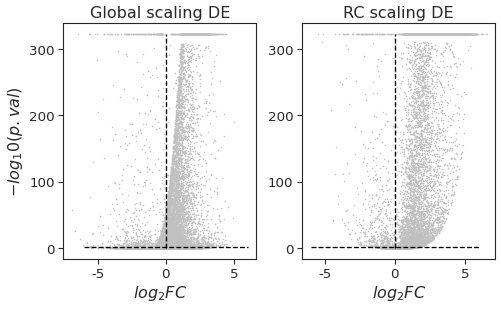

In [10]:
tm.vis.volcano_2DE(de_df)


Compare gene expression in global-scaling DE and ratio-corrected DE

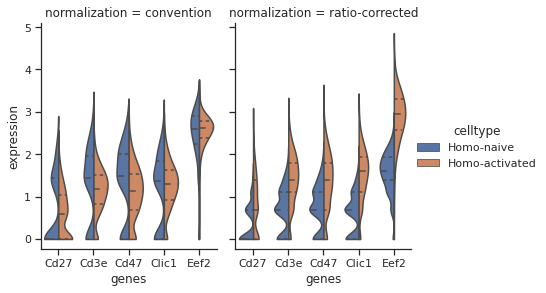

In [12]:
genes = ['Cd27','Cd3e','Cd47','Clic1','Eef2']#,'B2m']
fig = tm.vis.violin_2DE(adata_10k, adata_sgl_rc, genes,return_fig=True)
